# Discipline Feature Selection 

Building some ML models to predict unmatched rate as a means of exploratory analysis - unveiling the key factors that predict unmatched rate

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import eli5

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


### Load the Dataset

In [3]:
electives = pd.read_csv("../electives.csv").dropna().drop(["year", "disc_code", "discipline",'discipline_full'], axis=1)

In [4]:
electives.columns

Index(['prop_unmatched', 'prop_backup', 'competitiveness',
       'prop_matched_discipline_elective', 'prop_matched_program_elective',
       'prop_ranked_discipline_elective', 'prop_ranked_program_elective',
       'mean_electives_within_discipline', 'mean_electives_outside_discipline',
       'discipline_vs_other_electives', 'mean_other_disciplines',
       'prop_matched_3_discipline_elective'],
      dtype='object')

### Preprocessing

In [50]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import scipy.stats as stats

def model_eval_metrics(model, test_features, test_labels):

    predictions = model.predict(test_features)  
    rmse = np.sqrt(mean_squared_error(test_labels, predictions))
    print('Root Mean Squared Error:', round(np.mean(rmse),3))
    
    r2 = r2_score(test_labels, predictions)
    print('R-Squared:', round(r2,2))
    
    
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):

    # accuracy for testing
    print("\033[1m"+"\n\nModel Results for Training Set (n = 142)" + "\033[0m")
    model_eval_metrics(model, X_train, y_train)

    train_predictions = model.predict(X_train)
    trainpred = pd.DataFrame([train_predictions, y_train], index=["Predicted Unmatched Rate", "Observed Unmatched Rate"]).T
    sns.jointplot("Predicted Unmatched Rate", "Observed Unmatched Rate", trainpred).annotate(stats.pearsonr)
    plt.savefig(model_name+"_Training.png", dpi=320, height=4, width=4)
    plt.show()
    
    

    # accuracy for testing
    print("\033[1m"+"\n\nModel Results for Validation Set (n = 61)" + "\033[0m")
    model_eval_metrics(model, X_test, y_test)

    test_predictions = model.predict(X_test)
    testpred = pd.DataFrame([test_predictions, y_test], index=["Predicted Unmatched Rate", "Observed Unmatched Rate"]).T
    sns.jointplot("Predicted Unmatched Rate", "Observed Unmatched Rate", testpred).annotate(stats.pearsonr)
    plt.savefig(model_name+"_Validation.png", dpi=320, height=4, width=4)
    plt.show()


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# get feature and target arrays 
X = electives.drop(['prop_unmatched'], axis=1)
y = electives.prop_unmatched

# scale X
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

# get hold out dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [7]:
X.head()

,prop_backup,competitiveness,prop_matched_discipline_elective,prop_matched_program_elective,prop_ranked_discipline_elective,prop_ranked_program_elective,mean_electives_within_discipline,mean_electives_outside_discipline,discipline_vs_other_electives,mean_other_disciplines,prop_matched_3_discipline_elective
0,0.932559,-1.419686,0.239947,-1.114797,0.446316,-0.318563,-0.583112,0.713137,-0.755955,1.088762,0.081031
1,0.459542,0.627696,0.500140,0.111662,0.738446,0.062332,0.272675,-0.283599,0.140296,0.116480,0.761189
2,-0.962404,0.009737,0.637464,1.103267,0.717038,1.360105,0.865143,-1.169587,1.380543,-0.502245,1.239818
3,0.855839,1.927539,0.377021,0.262682,0.714855,1.324088,0.141015,0.048646,-0.114858,0.558427,0.348577
4,0.326477,-0.324959,0.322763,0.127729,0.696335,0.075309,0.009356,0.491640,-0.366774,1.088762,0.632668


## Random Forest Regressor

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf_base = RandomForestRegressor(n_jobs=-1, random_state = 1)

param_grid = { 
    'n_estimators': [100, 200, 500, 1000],
    'max_depth' : [2,3,4,5,6,7]
}

cv_rf = GridSearchCV(estimator=rf_base, param_grid=param_grid, cv=5)
cv_rf.fit(X_train, y_train)
print("\n Best Parameters from GridSearch:\n", cv_rf.best_params_)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=1,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=No

In [22]:
rf = RandomForestRegressor(n_jobs=-1, **cv_rf.best_params_)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)



Model Results for Training Set (n = 142)
Root Mean Squared Error: 0.021
Correlation: 0.96
R-Squared: 0.92


JointGrid annotation is deprecated and will be removed in a future release.


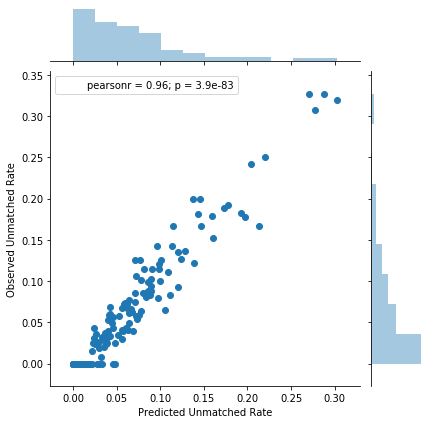



Model Results for Validation Set (n = 61)
Root Mean Squared Error: 0.058
Correlation: 0.8
R-Squared: 0.64


JointGrid annotation is deprecated and will be removed in a future release.


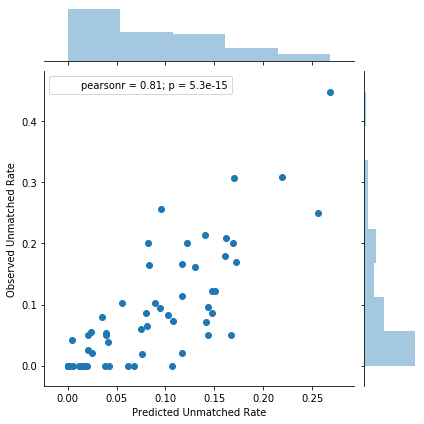

In [23]:
evaluate_model(rf, X_train, y_train, X_test, y_test, "RF")

In [24]:
X_train.columns.values

array(['prop_backup', 'competitiveness',
       'prop_matched_discipline_elective',
       'prop_matched_program_elective', 'prop_ranked_discipline_elective',
       'prop_ranked_program_elective', 'mean_electives_within_discipline',
       'mean_electives_outside_discipline',
       'discipline_vs_other_electives', 'mean_other_disciplines',
       'prop_matched_3_discipline_elective'], dtype=object)

In [25]:
rf_perm = eli5.sklearn.PermutationImportance(rf).fit(X_train, y_train)
eli5.explain_weights_df(rf_perm, top=50, feature_names=X_train.columns.values).drop('std',axis=1).style.background_gradient(cmap='viridis')

,feature,weight
0,competitiveness,0.463541
1,mean_electives_within_discipline,0.315786
2,discipline_vs_other_electives,0.082676
3,prop_ranked_discipline_elective,0.057755
4,prop_backup,0.053506
5,prop_matched_program_elective,0.041136
6,prop_matched_3_discipline_elective,0.017205
7,prop_ranked_program_elective,0.014833
8,mean_other_disciplines,0.014527
9,mean_electives_outside_discipline,0.010685


In [26]:
X_train.columns = ['Frequency of Parallel Applications', 'Competitiveness', 
                   'Prop Matched with Discipline Elective', 'Prop Matched with Program Elective', 
                   'Prop Ranked with Discipline Elective', 'Prop Ranked with Program Elective', 
                  'Mean Electives within Matched Discipline', 'Mean Electives outside Matched Discipline', 
                   'Mean Other Disciplines with Completed Electives', 'Prop Matched with ≥ 3 Discipline Electives', 
                   'Ratio of Electives within vs outside of Discipline']

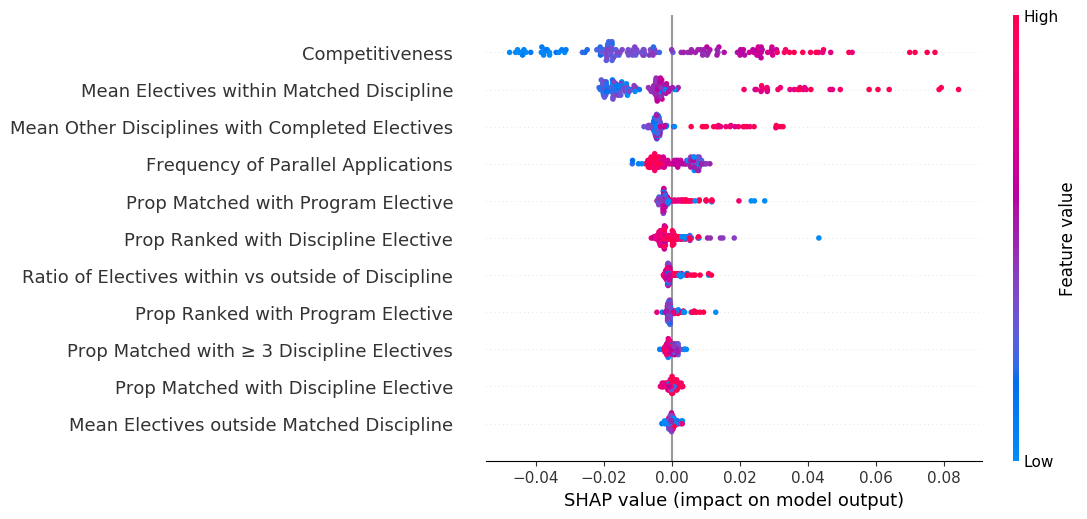

In [47]:
explainer = shap.TreeExplainer(rf, X_train)
shap_values = explainer.shap_values(X_train, check_additivity=False)

plt.figure(figsize=(3, 12), dpi=100)
shap.summary_plot(shap_values, X_train, show=False)
plt.savefig("RF_Shap_Plot.png", bbox_inches="tight")
plt.show()

## LASSO Regression 
With leave-one-out cross validation. Use this to keep the top features and eliminate extraneous features

In [55]:
from sklearn.linear_model import LassoCV

l1 = LassoCV(cv=X_train.shape[0], random_state=1, eps=0.01)
l1.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=142, eps=0.01, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=1, selection='cyclic',
        tol=0.0001, verbose=False)



Model Results for Training Set (n = 142)
Root Mean Squared Error: 0.046
R-Squared: 0.61


JointGrid annotation is deprecated and will be removed in a future release.


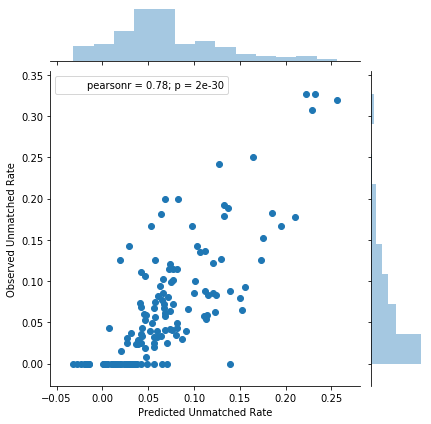



Model Results for Validation Set (n = 61)
Root Mean Squared Error: 0.062
R-Squared: 0.59


JointGrid annotation is deprecated and will be removed in a future release.


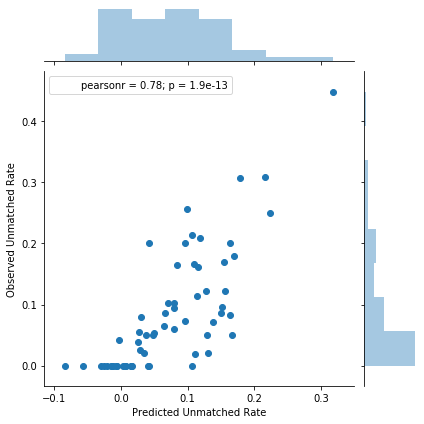

In [56]:
evaluate_model(l1, X_train, y_train, X_test, y_test, "LASSO")

In [58]:
l1_perm = eli5.sklearn.PermutationImportance(l1).fit(X_train, y_train)
eli5.explain_weights_df(l1_perm, top=50, feature_names=X_train.columns.values).drop('std',axis=1).style.background_gradient(cmap='viridis')

,feature,weight
0,Competitiveness,0.395364
1,Mean Electives within Matched Discipline,0.328587
2,Ratio of Electives within vs outside of Discipline,0.178185
3,Mean Other Disciplines with Completed Electives,0.106938
4,Prop Ranked with Program Elective,0.085657
5,Prop Ranked with Discipline Elective,0.060576
6,Prop Matched with Program Elective,0.037413
7,Frequency of Parallel Applications,0.003824
8,Prop Matched with ≥ 3 Discipline Electives,0.000983
9,Mean Electives outside Matched Discipline,0.000000


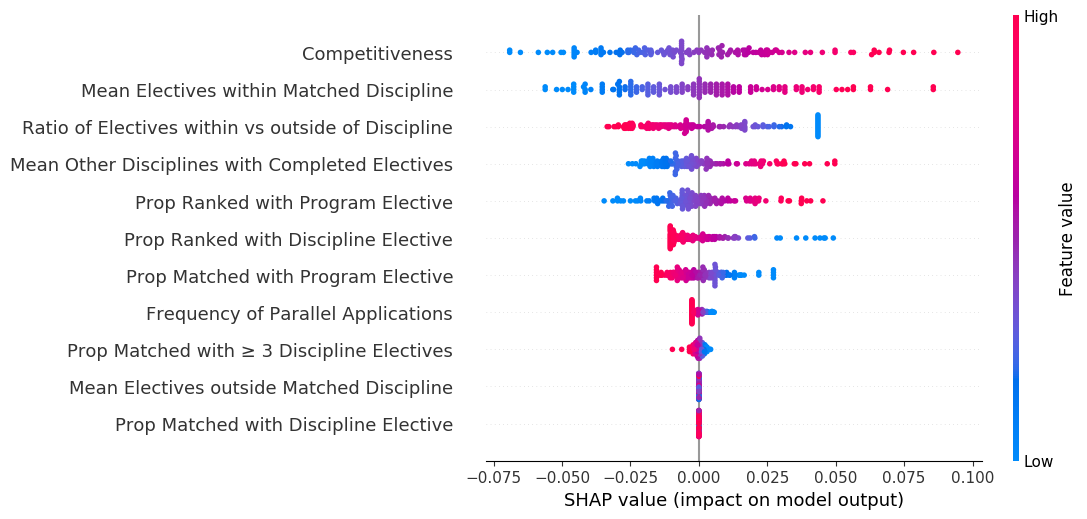

In [64]:
explainer = shap.LinearExplainer(l1, X_train)
shap_values = explainer.shap_values(X_train)


plt.figure(figsize=(3, 12), dpi=100)
shap.summary_plot(shap_values, X_train, show=False)
plt.savefig("LASSO_Shap_Plot.png", bbox_inches="tight")
plt.show()